#### 설정

In [ ]:
!pip install sec_edgar_api --quiet
!pip install sec_cik_mapper --quiet
!pip install curl_cffi --quiet

In [ ]:
# !pip install yfinance==0.2.54

In [ ]:
# !pip show yfinance

In [ ]:
from sec_edgar_api import EdgarClient
from datetime import datetime, timedelta
from sec_cik_mapper import StockMapper
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import time
import datetime
from io import StringIO
from curl_cffi import requests as curl_requests

import io
import csv
import json
import requests

stock_mapper = StockMapper()

In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader

#### 야후 파이낸스 데이터 불러오기

In [ ]:
start_date='2024-01-01'
end_date='2025-03-31'
GOOG_ticker='GOOG'
GOOGL_ticker = 'GOOGL'

In [ ]:
session = curl_requests.Session(impersonate="chrome")
GOOG1 = yf.Ticker(GOOG_ticker).history(period="5y")
GOOGL1 = yf.Ticker(GOOGL_ticker).history(period="5y")
# hist = GOOG.history(period="5y") # stock.history(start=start_date, end=end_date)

In [ ]:
GOOGL1

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-05-18 00:00:00-04:00,67.755073,69.306653,67.387825,68.929459,47094000,0.0,0.0
2020-05-19 00:00:00-04:00,68.944378,69.293204,68.361168,68.393013,31586000,0.0,0.0
2020-05-20 00:00:00-04:00,69.127500,70.265560,69.040916,70.122742,38262000,0.0,0.0
2020-05-21 00:00:00-04:00,70.213804,70.486002,69.387752,70.002815,30894000,0.0,0.0
2020-05-22 00:00:00-04:00,69.860994,70.512877,69.465387,70.325775,28544000,0.0,0.0
...,...,...,...,...,...,...,...
2025-05-12 00:00:00-04:00,157.490005,159.100006,156.250000,158.460007,44138800,0.0,0.0
2025-05-13 00:00:00-04:00,158.789993,160.570007,156.160004,159.529999,42382100,0.0,0.0
2025-05-14 00:00:00-04:00,159.960007,167.000000,159.610001,165.369995,48755900,0.0,0.0


#### 직접 다운 받은 데이터 전처리(야후 파이낸스 쓰면 불필요)

In [ ]:
# path1 = '/content/GOOGL_20200101tocurrent.csv'
# path2 = '/content/GOOG_20200101tocurrent.csv'
# # pandas로 읽어오기
# GOOGL1 = pd.read_csv(path1)
# GOOG1 = pd.read_csv(path2)

In [ ]:
GOOGL1

,Date,Price,Open,High,Low,Vol.,Change %
0,05/08/2025,154.28,155.00,155.93,152.90,57.50M,1.92%
1,05/07/2025,151.38,164.08,165.00,147.84,127.75M,-7.26%
2,05/06/2025,163.23,162.17,164.80,161.19,21.28M,-0.60%
3,05/05/2025,164.21,163.00,165.39,162.72,21.34M,0.11%
4,05/02/2025,164.03,163.40,164.97,161.87,25.72M,1.69%
...,...,...,...,...,...,...,...
1340,01/08/2020,70.25,69.74,70.59,69.63,35.33M,0.70%
1341,01/07/2020,69.76,70.02,70.17,69.58,34.53M,-0.19%
1342,01/06/2020,69.89,67.58,69.92,67.55,46.79M,2.66%
1343,01/03/2020,68.08,67.40,68.69,67.37,23.41M,-0.51%


In [ ]:
GOOGL1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345 entries, 0 to 1344
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1345 non-null   object 
 1   Price     1345 non-null   float64
 2   Open      1345 non-null   float64
 3   High      1345 non-null   float64
 4   Low       1345 non-null   float64
 5   Vol.      1345 non-null   object 
 6   Change %  1345 non-null   object 
dtypes: float64(4), object(3)
memory usage: 73.7+ KB


In [ ]:
GOOGL1['Date'] = pd.to_datetime(GOOGL1['Date'], format='%m/%d/%Y')
GOOGL1 = GOOGL1.set_index('Date')

GOOG1['Date'] = pd.to_datetime(GOOG1['Date'], format='%m/%d/%Y')
GOOG1 = GOOG1.set_index('Date')

KeyError: 'Date'

In [ ]:
GOOG1

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2025-05-08,155.75,155.92,157.41,154.10,38.39M,1.93%
2025-05-07,152.80,166.07,166.99,149.49,78.90M,-7.51%
2025-05-06,165.20,163.96,166.74,163.13,10.69M,-0.51%
2025-05-05,166.05,164.51,167.10,164.47,15.31M,0.14%
2025-05-02,165.81,164.96,166.70,163.66,16.84M,1.86%
...,...,...,...,...,...,...
2020-01-08,70.22,69.60,70.58,69.54,30.58M,0.79%
2020-01-07,69.67,69.90,70.15,69.52,30.23M,-0.06%
2020-01-06,69.71,67.50,69.83,67.50,34.66M,2.47%


In [ ]:
def parse_volume(x):
  if isinstance(x, str):
    x = x.strip().upper()
    # 접미사 매핑
    suffixes = {'K': 1e3, 'M': 1e6, 'B': 1e9}
    # 마지막 문자가 K/M/B 인지 확인
    if x[-1] in suffixes:
      num = float(x[:-1])  # 접미사 뗀 부분을 숫자로 변환
      return num * suffixes[x[-1]]
    else:
      # 접미사 없으면 그냥 float
      return float(x.replace(',', ''))
  # 이미 숫자면 그대로 리턴
  return float(x)

def parse_pct(x):
  if isinstance(x, str):
    # strip whitespace, remove trailing '%', convert to float and divide by 100
    return float(x.strip().rstrip('%')) / 100.0
  else:
    # if it’s already numeric
    return float(x)

In [ ]:
# Vol. 열에 함수 적용
GOOGL1['Vol.'] = GOOGL1['Vol.'].apply(parse_volume)
GOOG1['Vol.'] = GOOG1['Vol.'].apply(parse_volume)

In [ ]:
# Change % 열에 함수 적용
GOOGL1['Change %'] = GOOGL1['Change %'].apply(parse_pct)
GOOG1['Change %'] = GOOG1['Change %'].apply(parse_pct)

In [ ]:
GOOGL1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1345 entries, 2025-05-08 to 2020-01-02
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1345 non-null   float64
 1   Open      1345 non-null   float64
 2   High      1345 non-null   float64
 3   Low       1345 non-null   float64
 4   Vol.      1345 non-null   float64
 5   Change %  1345 non-null   float64
dtypes: float64(6)
memory usage: 73.6 KB


In [ ]:
GOOGL1

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2025-05-08,154.28,155.00,155.93,152.90,57500000.0,0.0192
2025-05-07,151.38,164.08,165.00,147.84,127750000.0,-0.0726
2025-05-06,163.23,162.17,164.80,161.19,21280000.0,-0.0060
2025-05-05,164.21,163.00,165.39,162.72,21340000.0,0.0011
2025-05-02,164.03,163.40,164.97,161.87,25720000.0,0.0169
...,...,...,...,...,...,...
2020-01-08,70.25,69.74,70.59,69.63,35330000.0,0.0070
2020-01-07,69.76,70.02,70.17,69.58,34530000.0,-0.0019
2020-01-06,69.89,67.58,69.92,67.55,46790000.0,0.0266


#### 스프레드 데이터 생성

In [ ]:
GOOGL1

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-05-18 00:00:00-04:00,67.755073,69.306653,67.387825,68.929459,47094000,0.0,0.0
2020-05-19 00:00:00-04:00,68.944378,69.293204,68.361168,68.393013,31586000,0.0,0.0
2020-05-20 00:00:00-04:00,69.127500,70.265560,69.040916,70.122742,38262000,0.0,0.0
2020-05-21 00:00:00-04:00,70.213804,70.486002,69.387752,70.002815,30894000,0.0,0.0
2020-05-22 00:00:00-04:00,69.860994,70.512877,69.465387,70.325775,28544000,0.0,0.0
...,...,...,...,...,...,...,...
2025-05-12 00:00:00-04:00,157.490005,159.100006,156.250000,158.460007,44138800,0.0,0.0
2025-05-13 00:00:00-04:00,158.789993,160.570007,156.160004,159.529999,42382100,0.0,0.0
2025-05-14 00:00:00-04:00,159.960007,167.000000,159.610001,165.369995,48755900,0.0,0.0


In [ ]:
# # 1) 인덱스 정렬 및 공통일자로 align (안정성 확보)
# GOOGL1 = GOOGL1.sort_index()
# GOOG1 = GOOG1.sort_index()
# GOOGL1, GOOG1 = GOOGL1.align(GOOG1, join='inner', axis=0)  # 공통 날짜만 남김

# 2) 각 컬럼별 spread 생성
spread_price = GOOGL1['Close'] - GOOG1['Close'] # 야후파이낸스는 Price 열 대신 Close
spread_open  = GOOGL1['Open']  - GOOG1['Open']
spread_high  = GOOGL1['High']  - GOOG1['High']
spread_low   = GOOGL1['Low']   - GOOG1['Low']
spread_vol   = GOOGL1['Volume']  - GOOG1['Volume']
# spread_vol   = GOOGL1['Vol.']  - GOOG1['Vol.'] # 야후 파이낸스는 Vol.이 아니라 Volume임

# (선택) 하나의 DataFrame으로 모아서 보고 싶다면
spread = pd.DataFrame({
  'spread_price': spread_price,
  'spread_open' : spread_open,
  'spread_high' : spread_high,
  'spread_low'  : spread_low,
  'spread_vol'  : spread_vol,
}, index=spread_open.index)

# 결과 확인
print(spread.head())

                           spread_price  spread_open  spread_high  spread_low  \
Date                                                                            
2020-05-18 00:00:00-04:00      0.058662    -0.011457     0.018583   -0.005472   
2020-05-19 00:00:00-04:00      0.042503    -0.078553     0.021308    0.010658   
2020-05-20 00:00:00-04:00      0.118309    -0.023970     0.076994    0.005390   
2020-05-21 00:00:00-04:00      0.193459     0.145671     0.045137    0.043690   
2020-05-22 00:00:00-04:00      0.137222     0.354711     0.207878    0.201956   

                           spread_vol  
Date                                   
2020-05-18 00:00:00-04:00    10646000  
2020-05-19 00:00:00-04:00     5974000  
2020-05-20 00:00:00-04:00     5154000  
2020-05-21 00:00:00-04:00     3194000  
2020-05-22 00:00:00-04:00     2356000  


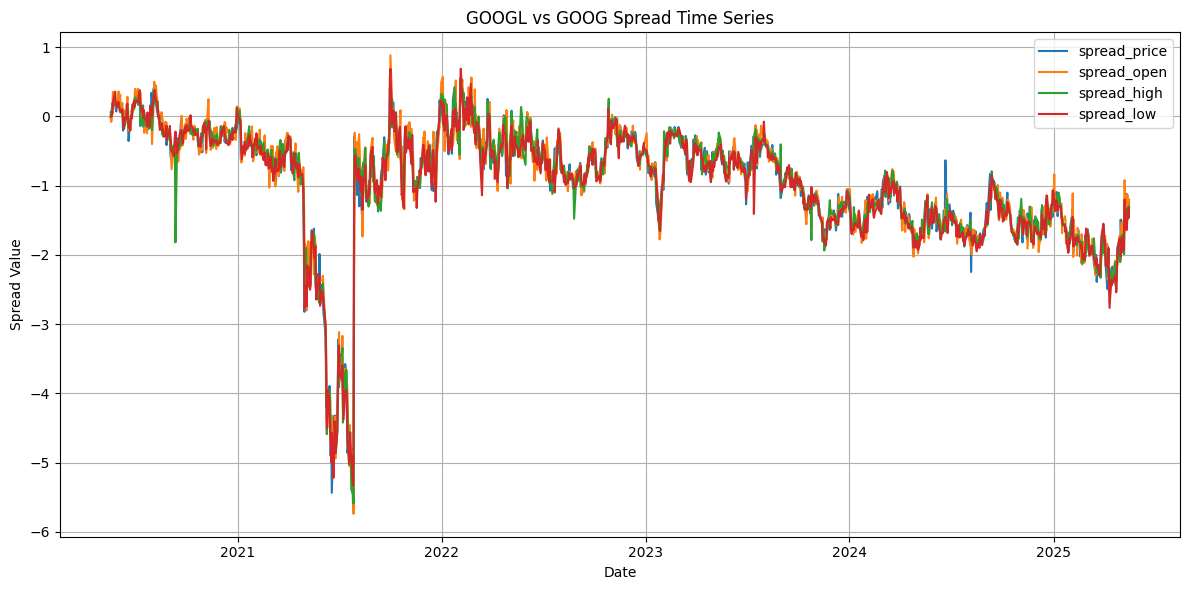

In [ ]:
plt.figure(figsize=(12, 6))
for col in spread.columns:
  if col != 'spread_vol':
    plt.plot(spread.index, spread[col], label=col)

plt.title('GOOGL vs GOOG Spread Time Series')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
spread_price.describe()

,Close
count,1257.000000
mean,-0.956998
std,0.860628
min,-5.588943
25%,-1.439331
50%,-0.769943
75%,-0.367935
max,0.431107


In [ ]:
print(sum(spread_price>spread_price.mean()))
print(sum(spread_price<spread_price.mean()))

740
517


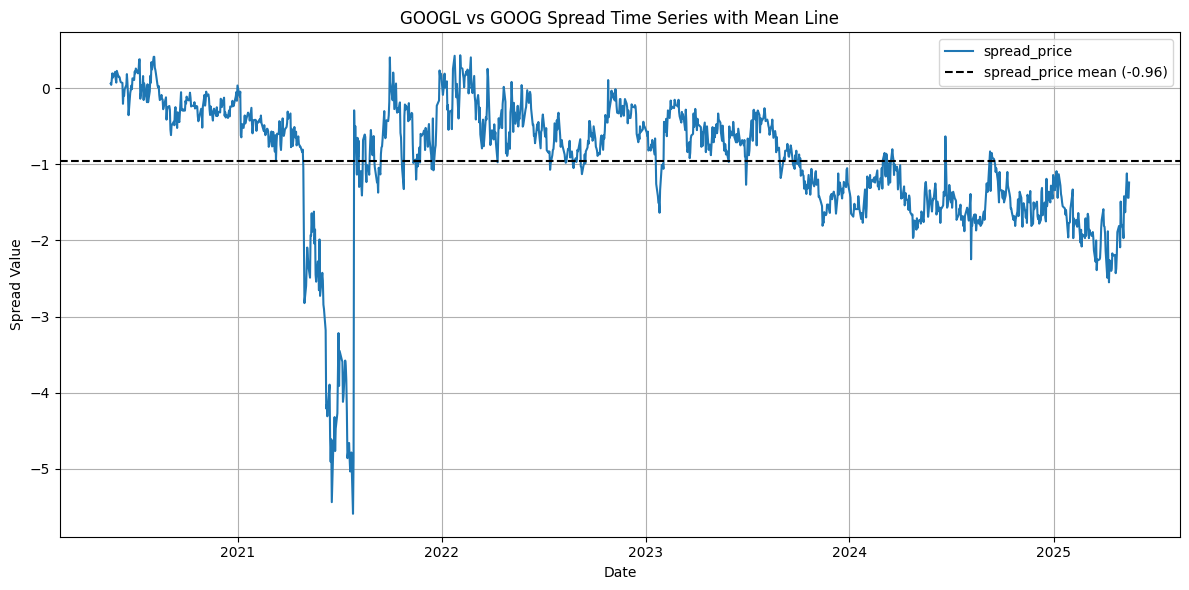

In [ ]:
# 3) spread_price 평균 계산
mean_sp = spread_price.mean()

# 4) 플롯 그리기
plt.figure(figsize=(12, 6))

plt.plot(spread_price.index, spread_price, label='spread_price')

# spread_price mean 선 추가
plt.axhline(
  y=mean_sp,
  color='black',
  linestyle='--',
  linewidth=1.5,
  label=f'spread_price mean ({mean_sp:.2f})'
)

plt.title('GOOGL vs GOOG Spread Time Series with Mean Line')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 1) 단순 변화량 (difference) → Series 변수
spread_price_diff = spread_price.diff()

# 2) 퍼센트 변화율 (percent change) → Series 변수
spread_price_pct_change = spread_price.pct_change()

# 3) 스프레드의 로그 수익률(변화율) (log return) → Series 변수
spread_price_log_return = np.log(spread_price / spread_price.shift(1))

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
spread_price_log_return

,Close
Date,
2020-05-18 00:00:00-04:00,NaN
2020-05-19 00:00:00-04:00,-0.322216
2020-05-20 00:00:00-04:00,1.023717
2020-05-21 00:00:00-04:00,0.491763
2020-05-22 00:00:00-04:00,-0.343461
...,...
2025-05-12 00:00:00-04:00,-0.375259
2025-05-13 00:00:00-04:00,0.194161
2025-05-14 00:00:00-04:00,0.057160


In [ ]:
# 전일 대비 스프레드 변화율이 음수면 스프레드가 줄어든 것.
print("전날 대비 스프레드 증가 건수 : ", sum(spread_price_log_return>0))
print("전날 대비 스프레드 감소 건수 : ", sum(spread_price_log_return<0))

전날 대비 스프레드 증가 건수 :  610
전날 대비 스프레드 감소 건수 :  596


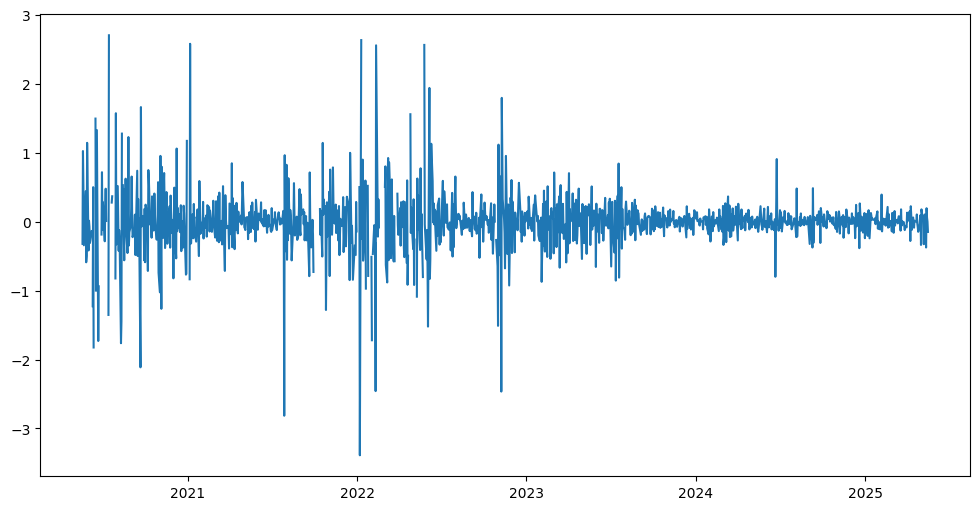

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(spread_price_log_return.index, spread_price_log_return, label='spread_price_pct_chg')

In [ ]:
# GOOGL1과 GOOG1은 비정상 시계열 데이터(p-val이 0.05보다 크면 비정상)
from statsmodels.tsa.stattools import adfuller

for series in [GOOGL1['Close'], GOOG1['Close']]:
  stat, pval, *_ = adfuller(series, regression='c')
  print(f'ADF p‑value = {pval:.3f}')

ADF p‑value = 0.507
ADF p‑value = 0.505


In [ ]:
# inf를 nan으로 바꾸고 nan 떨구기
spread_price_log_return.replace([np.inf, -np.inf], np.nan, inplace=True)
spread_price_log_return.dropna(inplace=True)

In [ ]:
# p-val이 0.05보다 크면 비정상(스프레드의 로그 변화율은 정상 시계열)
stat, pval, *_ = adfuller(spread_price_log_return, regression='c')
print(f'ADF p‑value = {pval:.3f}')

ADF p‑value = 0.000


#### 칼만필터 구현_ver1

In [ ]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 13.0 MB/s eta 0:00:00


In [ ]:
"""
### Pseudo Code

# 1) 스프레드 계산 (예: residual from OLS or simple difference)
beta = np.polyfit(price2, price1, 1)[0]
spread = price1 - beta * price2

# 2) 모델 추정 (예: ARMA(1,1))
from statsmodels.tsa.arima.model import ARIMA
arma = ARIMA(spread, order=(1,0,1)).fit()
params = arma.params
params['sigma2'] = arma.sigma2

# 3) 상태공간 행렬 구축
Z, T, R, H, Q = build_state_space_matrices(params, model_type='ARMA', order=(1,1))

# 4) 초기 상태와 분산: 무조건적 평균·분산
initial_state = np.zeros(Z.shape[1])
initial_covariance = np.linalg.solve(np.eye(T.shape[0]**2) - np.kron(T, T), R.dot(Q).dot(R.T).ravel()).reshape(T.shape)

# 5) k‑step 확률 계산
p_up, p_down = compute_conditional_probs(spread, Z, T, R, H, Q, initial_state, initial_covariance, k=25, c=0.0)

# 6) 시그널 생성
signals = generate_signals(spread.values, p_up, p_down, delta=0.005, p_up_star=0.8, p_down_star=0.8, c=0.0)

# 7) 백테스트
pl = backtest(spread, signals)

# 8) 결과 시각화
import matplotlib.pyplot as plt
plt.plot(pl); plt.title("Cumulative P&L"); plt.show()
"""

In [ ]:
# 칼만 필터 클래스(1차원 state model)
class KalmanFilter:
  def __init__(self, F, H, Q, R, x0, P0):
    self.F = F  # 상태 전이 모델
    self.H = H  # 측정 모델
    self.Q = Q  # 프로세스 잡음 공분산
    self.R = R  # 측정 잡음 공분산

    self.x_hat = x0  # 초기 상태 추정값 (a posteriori)
    self.P = P0    # 초기 오차 공분산 (a posteriori)

  def predict(self):
    # 상태 예측
    self.x_hat_minus = self.F * self.x_hat
    # 오차 공분산 예측
    self.P_minus = self.F * self.P * self.F.T + self.Q
    return self.x_hat_minus

  def update(self, z):
    # 칼만 이득 계산
    K = self.P_minus * self.H.T * np.linalg.inv(self.H * self.P_minus * self.H.T + self.R)
    # 상태 추정값 수정
    self.x_hat = self.x_hat_minus + K * (z - self.H * self.x_hat_minus)
    # 오차 공분산 수정
    self.P = (np.eye(self.F.shape[0]) - K * self.H) * self.P_minus
    return self.x_hat

In [ ]:
spread_series = spread_price_log_return.copy()

In [ ]:
spread_series.head()

,Close
Date,
2020-05-19 00:00:00-04:00,-0.322037
2020-05-20 00:00:00-04:00,1.023602
2020-05-21 00:00:00-04:00,0.491699
2020-05-22 00:00:00-04:00,-0.343406
2020-05-26 00:00:00-04:00,0.441269


In [ ]:
# 3. 칼만 필터 파라미터 설정
# 이 값들은 예시이며, 실제로는 데이터 기반으로 추정하거나 튜닝해야 합니다.

# 상태 변수: 스프레드 (1차원)
# 상태 전이 모델 (F): 스프레드가 이전 스프레드와 유사하게 유지된다고 가정 (랜덤 워크 또는 평균 회귀)
# 여기서는 스프레드가 이전 값 근처에 머무른다고 가정 (F=1)
theta = 0.1 # 평균 회귀 계수(속도)
F = np.array([[1.-theta]])  # 상태는 스칼라이지만 행렬 형태로 표현

# 측정 모델 (H): 우리가 직접 스프레드를 측정한다고 가정
H = np.array([[1.0]])

# 프로세스 잡음 공분산 (Q): 모델의 불확실성. 스프레드의 변동성.
# 스프레드의 일일 변화량의 분산을 사용할 수 있음 (예시)
daily_spread_changes = spread_series.diff().dropna()
Q_val = np.var(daily_spread_changes)
Q = np.array([[Q_val]])  # 또는 튜닝된 값

# 측정 잡음 공분산 (R): 측정의 불확실성.
# 실제로는 추정하기 어렵지만, 여기서는 작은 값으로 설정 (스프레드 자체를 측정하므로)
R_val = Q_val * 0.1 # Q에 비해 작은 값으로 설정 (가정)
R = np.array([[R_val]]) # 또는 튜닝된 값

# 초기 상태 추정값 (x0): 첫 번째 스프레드 값 또는 이동평균 등
x0 = np.array([[spread_series.iloc[0]]])

# 초기 오차 공분산 (P0): 초기 추정값의 불확실성. 충분히 큰 값으로 설정.
P0 = np.array([[1.0]]) # 또는 Q_val

# 4. 칼만 필터 초기화 및 실행
kf = KalmanFilter(F, H, Q, R, x0, P0)

In [ ]:
predictions = [] # 칼만 필터로 예측된 다음 시점 스프레드
estimates = []   # 칼만 필터로 추정된 현재 시점 스프레드 (측정값 반영 후)

for z_k in spread_series:
  # 1. 예측 단계
  x_hat_minus_k = kf.predict()
  predictions.append(x_hat_minus_k[0,0]) # 다음 시점 예측값 저장

  # 2. 수정 단계 (현재 시점의 실제 측정값 z_k 사용)
  x_hat_k = kf.update(np.array([[z_k]]))
  estimates.append(x_hat_k[0,0])       # 현재 시점 추정값 저장

df = pd.DataFrame()

df['Spread_Log_Return'] = spread_series # 실제 스프레드의 로그 수익률 값
df['KF_Prediction'] = predictions # t 시점에서 t+1 시점 예측
df['KF_Estimate'] = estimates     # t 시점의 측정값을 반영한 t 시점 추정
# 예측값은 한 칸씩 밀어서 비교 (predictions[i]는 i+1 시점의 예측)
df['KF_Prediction_Shifted'] = df['KF_Prediction'].shift(1)

#### 칼만필터 ver_1으로 매매 시뮬레이션

In [ ]:
# 5. 간단한 페어 트레이딩 시뮬레이션
# 스프레드 로그 수익률(변화율)의 장기 평균 계산 (예: 이동 평균)
window = 60 # 이동 평균 기간
df['Spread_Mean'] = spread_series.rolling(window=window).mean()
df['Spread_Std'] = spread_series.rolling(window=window).std()

# 진입/청산 임계값 (예: 1 표준편차)
entry_threshold = 1.0
exit_threshold = 0.0 # 평균으로 회귀하면 청산

# 다음 시점 스프레드 예측값을 사용
# df['Predicted_Spread_Next_Day'] = df['KF_Prediction'].shift(-1) # 예측은 이미 다음날 것을 의미하므로 shift 불필요

# 시그널 생성
df['Signal'] = 0 # 0: 중립, 1: 스프레드 매도 (GOOGL 매도, GOOG 매수), -1: 스프레드 매수 (GOOGL 매수, GOOG 매도)
df['Position'] = 0 # 현재 포지션

# 예측된 스프레드(df['KF_Prediction_Shifted'])가 장기 평균보다 높으면 매도, 낮으면 매수
# (df['KF_Prediction_Shifted']는 t-1 시점에 예측한 t 시점의 스프레드)

for i in range(window, len(df)):
  # 예측된 다음 시점 스프레드 (현재 i 시점의 예측은 i+1 시점의 스프레드 예측)
  # 하지만 거래는 현재 i 시점에서 예측을 바탕으로 하므로,
  # 전날(i-1)에 예측한 현재(i)의 스프레드 사용: df['KF_Prediction_Shifted'].iloc[i]
  predicted_spread_today = df['KF_Prediction_Shifted'].iloc[i]
  spread_mean_today = df['Spread_Mean'].iloc[i]
  spread_std_today = df['Spread_Std'].iloc[i]

  if pd.isna(predicted_spread_today) or pd.isna(spread_mean_today) or pd.isna(spread_std_today):
    continue

  # 매도 진입 (예측 스프레드가 평균 + 임계값보다 클 때)
  if df['Position'].iloc[i-1] == 0 and predicted_spread_today > spread_mean_today + entry_threshold * spread_std_today:
    df.loc[df.index[i], 'Signal'] = -1 # 스프레드 매도
    df.loc[df.index[i], 'Position'] = -1
  # 매수 진입 (예측 스프레드가 평균 - 임계값보다 작을 때)
  elif df['Position'].iloc[i-1] == 0 and predicted_spread_today < spread_mean_today - entry_threshold * spread_std_today:
    df.loc[df.index[i], 'Signal'] = 1  # 스프레드 매수
    df.loc[df.index[i], 'Position'] = 1
  # 포지션 유지 또는 청산
  elif df['Position'].iloc[i-1] == -1: # 현재 매도 포지션
    if predicted_spread_today <= spread_mean_today + exit_threshold * spread_std_today : # 평균으로 회귀하면 청산
      df.loc[df.index[i], 'Signal'] = 1 # 포지션 커버
      df.loc[df.index[i], 'Position'] = 0
    else:
      df.loc[df.index[i], 'Position'] = -1 # 포지션 유지
  elif df['Position'].iloc[i-1] == 1:  # 현재 매수 포지션
    if predicted_spread_today >= spread_mean_today - exit_threshold * spread_std_today: # 평균으로 회귀하면 청산
      df.loc[df.index[i], 'Signal'] = -1 # 포지션 커버
      df.loc[df.index[i], 'Position'] = 0
    else:
      df.loc[df.index[i], 'Position'] = 1 # 포지션 유지
  else:
    df.loc[df.index[i], 'Position'] = 0

#### 칼만필터 ver_1의 매매 시뮬레이션 결과

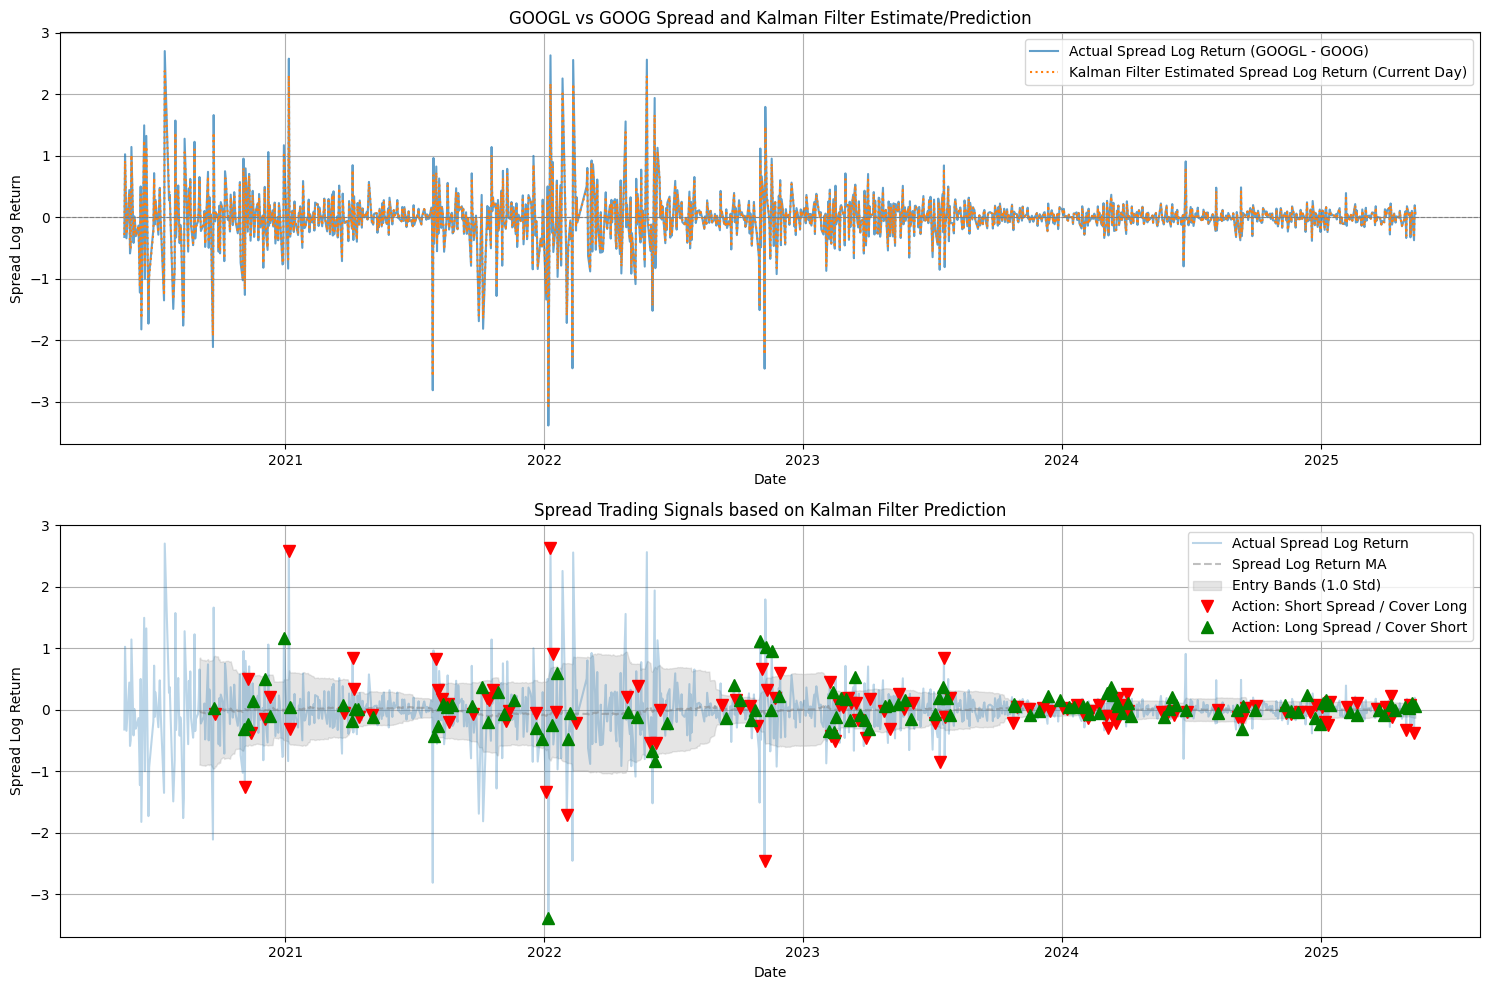

In [ ]:
# 6. 결과 시각화
plt.figure(figsize=(15, 10))

# 스프레드와 칼만 필터 추정치
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Spread_Log_Return'], label='Actual Spread Log Return (GOOGL - GOOG)', alpha=0.7)
# plt.plot(df.index, df['KF_Prediction_Shifted'], label='Kalman Filter Predicted Spread (Next Day)', linestyle='--')
plt.plot(df.index, df['KF_Estimate'], label='Kalman Filter Estimated Spread Log Return (Current Day)', linestyle=':')
# plt.plot(df.index, df['Spread_Mean'], label=f'{window}-day Moving Avg of Spread', color='red', linestyle='-.') # 실제 스프레드 로그 수익률의 이평선
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title('GOOGL vs GOOG Spread and Kalman Filter Estimate/Prediction')
plt.xlabel('Date')
plt.ylabel('Spread Log Return')
plt.legend()
plt.grid(True)

# 거래 시그널 시각화
plt.subplot(2, 1, 2)
plt.plot(df.index, df['Spread_Log_Return'], label='Actual Spread Log Return', alpha=0.3)
plt.plot(df.index, df['Spread_Mean'], label='Spread Log Return MA', color='grey', linestyle='--', alpha=0.5)
plt.fill_between(df.index,
                df['Spread_Mean'] - entry_threshold * df['Spread_Std'],
                df['Spread_Mean'] + entry_threshold * df['Spread_Std'],
                color='grey', alpha=0.2, label=f'Entry Bands ({entry_threshold} Std)') # 스프레드 로그 수익률 평균으로부터 1표준편차 떨어진 지점을 회색으로 색칠

# 매도 진입/청산
sell_signals = df[df['Signal'] == -1] # 스프레드 매도 시그널 (실제로는 포지션 진입 또는 청산 커버)
buy_signals = df[df['Signal'] == 1]  # 스프레드 매수 시그널

# 실제 거래 시점으로 표시
# -1 시그널: 스프레드 매도 진입 또는 스프레드 매수 청산
#  1 시그널: 스프레드 매수 진입 또는 스프레드 매도 청산
plt.plot(sell_signals.index, df.loc[sell_signals.index, 'Spread_Log_Return'], 'v', markersize=8, color='red', label='Action: Short Spread / Cover Long')
plt.plot(buy_signals.index, df.loc[buy_signals.index, 'Spread_Log_Return'], '^', markersize=8, color='green', label='Action: Long Spread / Cover Short')

plt.title('Spread Trading Signals based on Kalman Filter Prediction')
plt.xlabel('Date')
plt.ylabel('Spread Log Return')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

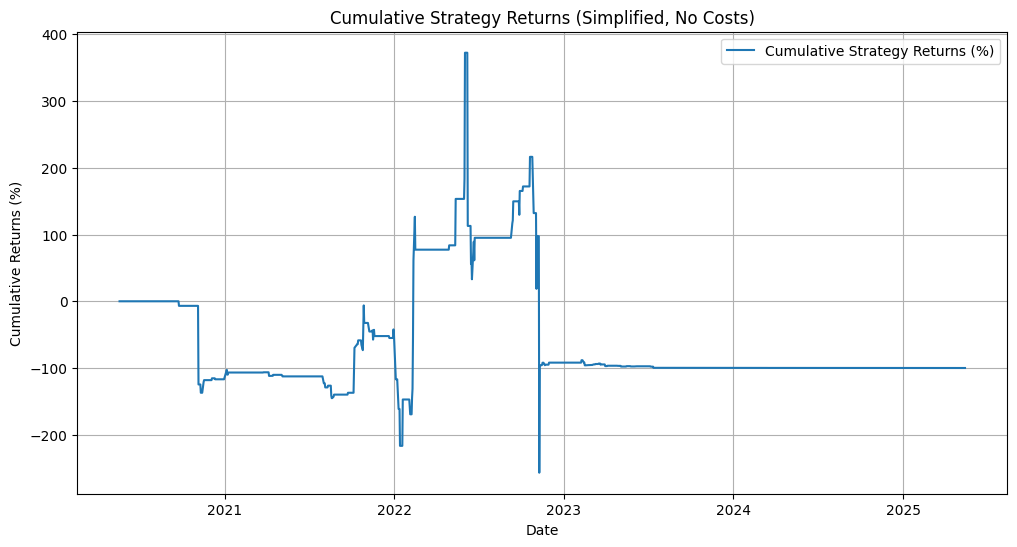


Sample of DataFrame with signals:


,Spread_Log_Return,KF_Prediction_Shifted,Spread_Mean,Signal,Position,Strategy_Returns
Date,,,,,,
2025-04-16 00:00:00-04:00,-0.088162,0.042337,0.005281,0,0,-0.000000
2025-04-17 00:00:00-04:00,0.013730,-0.007111,0.004688,0,0,0.000000
2025-04-21 00:00:00-04:00,-0.004553,-0.073133,0.005225,0,0,-0.000000
2025-04-22 00:00:00-04:00,0.103986,0.005698,0.006047,0,0,0.000000
2025-04-23 00:00:00-04:00,-0.025000,-0.003312,0.003164,0,0,-0.000000
2025-04-24 00:00:00-04:00,-0.078985,0.085362,0.003545,0,0,-0.000000
2025-04-25 00:00:00-04:00,-0.147326,-0.014041,0.001090,0,0,-0.000000
2025-04-28 00:00:00-04:00,-0.043251,-0.066108,0.000462,0,0,-0.000000
2025-04-29 00:00:00-04:00,0.048525,-0.126368,0.003066,1,1,0.000000


In [ ]:
# 간단한 수익률 계산(거래 비용 미고려)
df['Strategy_Returns'] = df['Position'].shift(1) * df['Spread_Log_Return'] # 만약 df에 Spread라는 이름으로 Spread 자체를 예측한 값을 저장한다면 df['Spread'].diff() # (어제의 포지션) * (오늘의 스프레드 변화)
cumulative_strategy_returns = (1 + df['Strategy_Returns'].fillna(0)).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy_returns.index, cumulative_strategy_returns * 100, label='Cumulative Strategy Returns (%)')
plt.title('Cumulative Strategy Returns (Simplified, No Costs)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (%)')
plt.legend()
plt.grid(True)
plt.show()

print("\nSample of DataFrame with signals:")
df[['Spread_Log_Return', 'KF_Prediction_Shifted', 'Spread_Mean', 'Signal', 'Position', 'Strategy_Returns']].tail(20)

#### 칼만필터 w/ 딥러닝(칼만필터로 스프레드 벡터 만들고 이 벡터를 LSTM에 넣어 예측)

In [ ]:
class SpreadLSTM(nn.Module):
  def __init__(self, input_size=2, hidden_size=64, num_layers=2, dropout=0.2):
    # # [raw, KF_pred]
    super().__init__()
    self.lstm = nn.LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True,
        dropout=dropout if num_layers>1 else 0.0
    )
    # 마지막 타임스텝의 hidden → 예측 스칼라
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    # x: [batch, seq_len, 2]
    lstm_out, _ = self.lstm(x)
    # lstm_out: [batch, seq_len, hidden_size]
    last = lstm_out[:, -1, :]
    # last: [batch, hidden_size]
    out = self.fc(last)
    # out: [batch, 1]
    return out

In [ ]:
model = SpreadLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(epochs):
  for x_batch, y_batch in train_loader:
    # x_batch: [B, T, 2], y_batch: [B, 1]
    y_pred = model(x_batch)
    loss = criterion(y_pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}: loss = {loss.item():.4f}")

In [ ]:
model.eval()
predictions = []
targets     = []

with torch.no_grad():
  for x_batch, y_batch in test_loader:
    y_pred = model(x_batch)         # [B,1]
    predictions.append(y_pred)      # 모아두기
    targets.append(y_batch)

# 전체를 하나의 Tensor로 합치기
preds = torch.cat(predictions, dim=0)  # [N,1]
trues = torch.cat(targets, dim=0)  # [N,1]

#### 데이터준비 ver.2 (단순 스프레드, 딥러닝용)

In [ ]:
##############################################################################################################
####                                           데이터 준비                                                ####
##############################################################################################################
ticker_a = 'GOOGL'
ticker_c = 'GOOG'
df = pd.DataFrame({ticker_a: GOOGL1['Close'], ticker_c: GOOG1['Close']})
df.ffill(inplace=True)
df.bfill(inplace=True) # 혹시 모를 시작 부분 결측치도 이전 값으로 채움 (ffill 후 bfill)
df.dropna(inplace=True) # 그래도 남은 결측치 제거 (데이터가 충분하지 않을 경우)

if df.empty:
  raise ValueError("데이터를 불러오지 못했거나 데이터가 비어있습니다. 티커와 날짜를 확인하세요.")

df['Spread'] = df[ticker_a] - df[ticker_c]
spread_values = df['Spread'].values.astype(np.float32) # Numpy 배열로 변환

# 2. 시계열 데이터를 지도 학습 형태로 변환하는 함수
def create_sequences(data, seq_length):
  """
  굳이 리스트를 안 만들고 바로
  xs = np.empty((num_samples, seq_length), dtype=data.dtype)
  ys = np.empty((num_samples,), dtype=data.dtype)
  이렇게 초기화해서 array에 넣어도 됨. X나 Y의 경우 return 되는 값이 numpy.array로 한 번 더 덧씌워진 꼴이라 맨 끝 차원에 1이 붙는데, 어차피 그 값은 안 써서.
  """
  xs = []
  ys = []
  for i in range(len(data) - seq_length):
    x = data[i:(i + seq_length)]
    y = data[i + seq_length] # 다음 시점의 값을 예측
    xs.append(x)
    ys.append(y)
  return np.array(xs), np.array(ys)

sequence_length = 60  # 예: 과거 60일의 스프레드를 보고 다음 날 스프레드 예측
X, y = create_sequences(spread_values, sequence_length)

# X는 (num_samples, seq_length) 형태, y는 (num_samples,) 형태가 됨
# 모델 입력에 맞게 X의 차원을 (num_samples, seq_length, 1)로 변경
if X.ndim == 2:
  X = np.expand_dims(X, axis=2)
if y.ndim == 1:
  y = np.expand_dims(y, axis=1)

print(f"X shape: {X.shape}, y shape: {y.shape}") # 예: (1446, 60, 1), (1446, 1)

if X.shape[0] == 0:
  raise ValueError(f"시퀀스 생성 후 데이터가 없습니다. 데이터 기간이나 sequence_length({sequence_length})를 확인하세요.")

# 3. 데이터 분할 (훈련, 검증, 테스트)
# 시계열 데이터이므로 순서대로 분할
total_samples = X.shape[0]
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.15)
# test_size = total_samples - train_size - val_size # 나머지를 테스트로

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f"Train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation shapes: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")

# 4. 정규화 (MinMaxScaler 사용)
# 중요: Scaler는 훈련 데이터에만 fit 하고, 그 scaler를 사용하여 검증/테스트 데이터 변환
#       스프레드 값 자체를 스케일링
scaler_spread = MinMaxScaler(feature_range=(-1, 1))

# X 데이터 정규화 (각 시퀀스 내부의 값들을 정규화)
# (num_samples, seq_length, 1) -> (num_samples * seq_length, 1)로 reshape 후 fit_transform
X_train_reshaped = X_train.reshape(-1, 1)
scaler_spread.fit(X_train_reshaped) # 훈련 데이터의 스프레드 값으로 스케일러 학습

X_train_scaled = scaler_spread.transform(X_train_reshaped).reshape(X_train.shape)
X_val_scaled = scaler_spread.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
X_test_scaled = scaler_spread.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# y 데이터 정규화 (타겟 값도 동일한 스케일러로 변환)
y_train_scaled = scaler_spread.transform(y_train)
y_val_scaled = scaler_spread.transform(y_val)
y_test_scaled = scaler_spread.transform(y_test)

# 5. PyTorch Tensor로 변환 및 DataLoader 생성
batch_size_dl = 32 # DataLoader에서 사용할 배치 크기

# 훈련/검증/테스트 데이터셋 텐서로 변환
train_features = torch.tensor(X_train_scaled, dtype=torch.float32)
train_targets = torch.tensor(y_train_scaled, dtype=torch.float32)
val_features = torch.tensor(X_val_scaled, dtype=torch.float32)
val_targets = torch.tensor(y_val_scaled, dtype=torch.float32)
test_features = torch.tensor(X_test_scaled, dtype=torch.float32)
test_targets = torch.tensor(y_test_scaled, dtype=torch.float32)

# 데이터셋을 텐서로 생성 (예측에 쓰일 feature와 target을 하나의 셋으로)
train_dataset = TensorDataset(train_features, train_targets)
val_dataset = TensorDataset(val_features, val_targets)
test_dataset = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train_dataset, batch_size=batch_size_dl, shuffle=False) # 시계열은 보통 shuffle=False
val_loader = DataLoader(val_dataset, batch_size=batch_size_dl, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size_dl, shuffle=False)

print("\nDataLoaders created.")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

##############################################################################################################
####                                           데이터 준비                                                ####
##############################################################################################################

X shape: (1197, 60, 1), y shape: (1197, 1)
Train shapes: X_train: (837, 60, 1), y_train: (837, 1)
Validation shapes: X_val: (179, 60, 1), y_val: (179, 1)
Test shapes: X_test: (181, 60, 1), y_test: (181, 1)

DataLoaders created.
Number of training batches: 27
Number of validation batches: 6
Number of testing batches: 6


#### 칼만필터 w/ 딥러닝(칼만레이어)

LSTM으로 예측한 스프레드를 관측값으로써 칼만필터에 넘겨주는 딥러닝 모형

In [ ]:
class KalmanFilter1D(nn.Module):
  def __init__(self, F_val=None, H_val=None, Q_val=None, R_val=None, initial_x_hat_val=0.0, initial_P_val=1.0, trainable_params=None):
    """
    1차원 칼만 필터 레이어 (스프레드 예측용)

    Args:
      F_val (float, optional): 상태 전이 모델 F의 값. 기본값은 0.9 (평균 회귀).
      H_val (float, optional): 측정 모델 H의 값. 기본값은 1.0.
      Q_val (float, optional): 프로세스 잡음 공분산 Q의 값. 기본값은 0.01.
      R_val (float, optional): 측정 잡음 공분산 R의 값. 기본값은 0.1.
      initial_x_hat_val (float, optional): 초기 상태 추정값 x_hat_0. 기본값은 0.0.
      initial_P_val (float, optional): 초기 오차 공분산 P_0. 기본값은 1.0.
      trainable_params (list of str, optional): 학습 가능하게 만들 파라미터 이름 리스트.
                                              예: ['Q', 'R']. 기본값은 None (모두 고정).
    """
    super(KalmanFilter1D, self).__init__()

    self.trainable_params = trainable_params if trainable_params is not None else []

    # 상태 전이 모델 F
    _F_val = F_val if F_val is not None else 0.9 # 평균 회귀 가정 시 (1-theta)
    if 'F' in self.trainable_params:
      self.F = nn.Parameter(torch.tensor([[_F_val]], dtype=torch.float32))
    else:
      self.register_buffer('F', torch.tensor([[_F_val]], dtype=torch.float32)) # 고정값

    # 측정 모델 H
    _H_val = H_val if H_val is not None else 1.0
    if 'H' in self.trainable_params: # H는 보통 고정이지만, 예시를 위해 추가
      self.H = nn.Parameter(torch.tensor([[_H_val]], dtype=torch.float32))
    else:
      self.register_buffer('H', torch.tensor([[_H_val]], dtype=torch.float32))

    # 프로세스 잡음 공분산 Q
    _Q_val = Q_val if Q_val is not None else 0.01
    if 'Q' in self.trainable_params:
      # Q는 항상 양수여야 하므로, log 공간에서 학습하고 exp를 취하거나 softplus 사용
      # 여기서는 간단히 nn.Parameter 사용. 필요시 제약 조건 추가.
      self.log_Q_sqrt = nn.Parameter(torch.log(torch.sqrt(torch.tensor([[_Q_val]], dtype=torch.float32))))
    else:
      self.register_buffer('Q', torch.tensor([[_Q_val]], dtype=torch.float32))

    # 측정 잡음 공분산 R
    _R_val = R_val if R_val is not None else 0.1
    if 'R' in self.trainable_params:
      self.log_R_sqrt = nn.Parameter(torch.log(torch.sqrt(torch.tensor([[_R_val]], dtype=torch.float32))))
    else:
      self.register_buffer('R', torch.tensor([[_R_val]], dtype=torch.float32))

    # 초기 상태
    # 여기서는 고정값으로 사용하거나, forward 시 입력으로 받는 것을 고려
    self.initial_x_hat_val = initial_x_hat_val
    self.initial_P_val = initial_P_val

    # 1x1 단위 행렬
    self.register_buffer('I', torch.eye(1, dtype=torch.float32))


  # Q와 R이 학습 가능한 경우, 저장된 파라미터로부터 실제 Q, R 값을 계산하여 반환.
  def get_Q(self):
    if 'Q' in self.trainable_params:
      return torch.exp(self.log_Q_sqrt * 2) # Q = (sqrt_Q)^2, to ensure Q > 0
    else:
      return self.Q

  def get_R(self):
    if 'R' in self.trainable_params:
      return torch.exp(self.log_R_sqrt * 2) # R = (sqrt_R)^2, to ensure R > 0
    else:
      return self.R

  def forward(self, measurements, initial_x_hat=None, initial_P=None):
    """
    칼만 필터 순전파

    Args:
      measurements (Tensor): 측정값 시퀀스. (batch_size, seq_len, 1) 또는 (seq_len, 1) 또는 (batch_size, seq_len) -> (batch_size, seq_len, 1)로 변환
      initial_x_hat (Tensor, optional): 배치별 초기 상태 추정값 (batch_size, 1, 1). None이면 self.initial_x_hat_val 사용.
      initial_P (Tensor, optional): 배치별 초기 오차 공분산 (batch_size, 1, 1). None이면 self.initial_P_val 사용.

    Returns:
      x_hat_sequence (Tensor): 각 시점의 사후 상태 추정값 시퀀스 (batch_size, seq_len, 1)
      P_sequence (Tensor): 각 시점의 사후 오차 공분산 시퀀스 (batch_size, seq_len, 1, 1)
      x_hat_minus_sequence (Tensor): 각 시점의 사전 상태 추정값(예측값) 시퀀스 (batch_size, seq_len, 1)
    """
    # 입력 차원 확인 및 조정(굳이 하지 않아도 되긴 함)
    if measurements.ndim == 1: # (seq_len)
      measurements = measurements.unsqueeze(0).unsqueeze(-1) # (1, seq_len, 1)
    elif measurements.ndim == 2: # (batch_size, seq_len) or (seq_len, feature_dim=1)
      if measurements.size(1) == 1 and measurements.size(0) != 1 : # (seq_len, 1)
        measurements = measurements.unsqueeze(0) # (1, seq_len, 1)
      else: # (batch_size, seq_len)
        measurements = measurements.unsqueeze(-1) # (batch_size, seq_len, 1)

    batch_size = measurements.size(0)
    seq_len = measurements.size(1)

    # 초기 상태 설정
    if initial_x_hat is None:
      x_hat = torch.full((batch_size, 1, 1), self.initial_x_hat_val, device=measurements.device, dtype=torch.float32)
    else:
      x_hat = initial_x_hat.clone() # (batch_size, 1, 1)

    if initial_P is None:
      P = torch.full((batch_size, 1, 1), self.initial_P_val, device=measurements.device, dtype=torch.float32)
    else:
      P = initial_P.clone() # (batch_size, 1, 1)

    # 결과를 저장할 리스트
    x_hat_sequence = []
    P_sequence = []
    x_hat_minus_sequence = []

    current_Q = self.get_Q().expand(batch_size, 1, 1)
    current_R = self.get_R().expand(batch_size, 1, 1)
    current_F = self.F.expand(batch_size, 1, 1)
    current_H = self.H.expand(batch_size, 1, 1)
    current_I = self.I.expand(batch_size, 1, 1)


    for t in range(seq_len):
      # 1. 예측 단계
      # x_hat_minus_k = F * x_hat_{k-1}
      x_hat_minus = torch.bmm(current_F, x_hat) # (b, 1, 1) = (b, 1, 1) @ (b, 1, 1)
      # P_minus_k = F * P_{k-1} * F^T + Q
      P_minus = torch.bmm(torch.bmm(current_F, P), current_F.transpose(1, 2)) + current_Q # (b,1,1)

      # 현재 시점의 측정값
      z_k = measurements[:, t, :].unsqueeze(-1) # (batch_size, 1, 1)

      # 2. 수정 단계
      # 칼만 이득 K_k = P_minus_k * H^T * (H * P_minus_k * H^T + R)^-1
      H_P_minus_HT = torch.bmm(torch.bmm(current_H, P_minus), current_H.transpose(1, 2)) # (b,1,1)
      S_k = H_P_minus_HT + current_R # 이노베이션 공분산 (b,1,1)
      K = torch.bmm(torch.bmm(P_minus, current_H.transpose(1, 2)), torch.inverse(S_k)) # (b,1,1)

      # 상태 추정값 수정 x_hat_k = x_hat_minus_k + K_k * (z_k - H * x_hat_minus_k)
      innovation = z_k - torch.bmm(current_H, x_hat_minus) # (b,1,1)
      x_hat = x_hat_minus + torch.bmm(K, innovation) # (b,1,1)

      # 오차 공분산 수정 P_k = (I - K_k * H) * P_minus_k
      P = torch.bmm((current_I - torch.bmm(K, current_H)), P_minus) # (b,1,1)

      x_hat_sequence.append(x_hat.squeeze(-1)) # (b, 1)
      P_sequence.append(P)                     # (b, 1, 1)
      x_hat_minus_sequence.append(x_hat_minus.squeeze(-1)) # (b, 1)


    # 리스트들을 텐서로 변환
    # (batch_size, seq_len, 1)
    x_hat_sequence = torch.stack(x_hat_sequence, dim=1)
    # (batch_size, seq_len, 1, 1)
    P_sequence = torch.stack(P_sequence, dim=1)
    # (batch_size, seq_len, 1)
    x_hat_minus_sequence = torch.stack(x_hat_minus_sequence, dim=1)

    return x_hat_sequence, P_sequence, x_hat_minus_sequence

In [ ]:
# 만약 파라미터가 학습 가능하도록 설정했다면, 딥러닝 모델의 일부로 사용 가능
# 예시: 딥러닝 모델 내부에 칼만 필터 레이어 사용
class HybridModel(nn.Module):
  def __init__(self, lstm_hidden_size, kf_layer_instance):
    super(HybridModel, self).__init__()
    # 예시: LSTM으로 특징 추출 또는 사전 예측
    self.lstm = nn.LSTM(input_size=1, hidden_size=lstm_hidden_size, batch_first=True)
    self.fc_for_kf_input = nn.Linear(lstm_hidden_size, 1) # LSTM 출력을 KF 측정값으로 변환

    self.kf_layer = kf_layer_instance # 미리 생성한 KF 레이어 사용

    # KF 출력 이후 추가 처리 (예시)
    self.fc_final = nn.Linear(1, 1) # KF의 추정된 상태를 최종 예측으로

  def forward(self, x_sequence, initial_kf_x_hat=None, initial_kf_P=None):
    # x_sequence: (batch_size, seq_len, input_features=1)

    # 1. LSTM으로 특징 추출 또는 사전 예측 (예시)
    lstm_out, _ = self.lstm(x_sequence) # (batch_size, seq_len, lstm_hidden_size)
    # LSTM 출력을 KF가 사용할 측정값 형태로 변환 (여기서는 각 시점의 스칼라 값으로 가정)
    kf_measurements = self.fc_for_kf_input(lstm_out) # (batch_size, seq_len, 1)

    # 2. 칼만 필터 레이어 통과
    # kf_measurements를 칼만 필터의 '측정값'으로 사용
    # (다른 방법론으로써)또는 x_sequence 자체를 측정값으로 사용하고, LSTM은 Q,R 등을 예측하는데 사용할 수도 있음 (설계에 따라 다름)
    kf_x_hat_seq, kf_P_seq, kf_x_hat_minus_seq = self.kf_layer(
      kf_measurements, # LSTM으로 예측한 x_sequence(스프레드)
      initial_x_hat=initial_kf_x_hat,
      initial_P=initial_kf_P
    )
    # kf_x_hat_seq는 각 시점의 칼만 필터링된 상태 (스프레드 추정치) (b, seq_len, 1)

    # 3. KF 출력 후처리 (예시)
    final_prediction = self.fc_final(kf_x_hat_seq) # (b, seq_len, 1)

    # 일반적으로 시계열 예측에서는 마지막 시점의 예측을 사용하거나,
    # 혹은 전체 시퀀스를 다른 방식으로 활용할 수 있음
    return final_prediction[:, -1, :] # final_prediction # 또는 final_prediction[:, -1, :] 등

In [ ]:
# 모델 인스턴스 생성 (이전과 동일한 KF 파라미터 사용)
F_param = 1.0 - 0.1 # theta = 0.1
H_param = 1.0
Q_param = 0.01
R_param = 0.1
lstm_hidden_dl = 64 # LSTM 은닉층 크기

kf_layer_for_model = KalmanFilter1D(F_val=F_param, H_val=H_param, Q_val=Q_param, R_val=R_param, trainable_params=['Q', 'R'])
model_to_train = HybridModel(lstm_hidden_size=lstm_hidden_dl, kf_layer_instance=kf_layer_for_model)

# 모델, 손실 함수, 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_to_train.parameters(), lr=0.001)

# 훈련 루프
num_epochs = 10 # 실제 훈련 시에는 더 많은 epoch 필요
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_to_train.to(device)

print(f"\nStarting training on {device}...")

all_predictions_val = []
all_actuals_val = []
for epoch in range(num_epochs):
  model_to_train.train() # 훈련 모드
  train_loss = 0.0
  for batch_x, batch_y in train_loader:
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)

    # 칼만 필터의 초기 상태 (매 배치 또는 매 에폭마다 초기화하거나, 이전 상태를 이어받도록 설계 가능)
    # 여기서는 간단히 매번 0과 1로 초기화된 값을 사용 (더 나은 방법 고민 필요)
    current_batch_size = batch_x.size(0)
    initial_kf_x_hat_batch = torch.zeros(current_batch_size, 1, 1, device=device)
    initial_kf_P_batch = torch.ones(current_batch_size, 1, 1, device=device)

    optimizer.zero_grad()
    outputs = model_to_train(batch_x, initial_kf_x_hat_batch, initial_kf_P_batch)
    # HybridModel의 출력이 (batch, seq_len, 1) 이므로, 타겟 y도 (batch, 1) 이라면
    # outputs[:, -1, :] 와 같이 마지막 시점의 예측만 사용하거나, 모델 출력 구조를 맞춰야 함.
    # 현재 create_sequences에서 y는 다음 '하나'의 값이므로, 모델 출력도 그에 맞춰야 함.
    # HybridModel의 forward 마지막을 return final_prediction[:, -1, :] 로 하거나
    # 여기서 loss = criterion(outputs[:, -1, :], batch_y) 로 계산.
    # 여기서는 HybridModel의 fc_final 출력이 이미 (batch, seq_len, 1)이므로
    # 타겟 y가 (batch, 1) 형태이므로, outputs의 마지막 시점 예측을 사용.
    loss = criterion(outputs[:, -1, :], batch_y) # 마지막 시점 예측과 타겟 비교
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * batch_x.size(0)

  train_loss /= len(train_loader.dataset)

  # 검증 루프 (유사하게 구현)
  model_to_train.eval() # 평가 모드
  val_loss = 0.0
  with torch.no_grad():
    for batch_x_val, batch_y_val in val_loader:
      batch_x_val, batch_y_val = batch_x_val.to(device), batch_y_val.to(device)
      current_batch_size_val = batch_x_val.size(0)
      initial_kf_x_hat_batch_val = torch.zeros(current_batch_size_val, 1, 1, device=device)
      initial_kf_P_batch_val = torch.ones(current_batch_size_val, 1, 1, device=device)

      outputs_val = model_to_train(batch_x_val, initial_kf_x_hat_batch_val, initial_kf_P_batch_val)
      loss_val = criterion(outputs_val[:, -1, :], batch_y_val)
      val_loss += loss_val.item() * batch_x_val.size(0)

      all_predictions_val.append(outputs_val.cpu().numpy())
      all_actuals_val.append(batch_y_val.cpu().numpy())
  val_loss /= len(val_loader.dataset)

  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}")

print("\nTraining finished (example).")

# 테스트 세트로 최종 평가 (유사하게 구현)
# 예측값을 원래 스케일로 되돌리려면 scaler_spread.inverse_transform 사용


Starting training on cpu...
Epoch [1/10], Train Loss: 1.315107, Validation Loss: 0.579999
Epoch [2/10], Train Loss: 0.749269, Validation Loss: 0.131003
Epoch [3/10], Train Loss: 0.245154, Validation Loss: 0.011539
Epoch [4/10], Train Loss: 0.096197, Validation Loss: 0.064538
Epoch [5/10], Train Loss: 0.091151, Validation Loss: 0.064069
Epoch [6/10], Train Loss: 0.091035, Validation Loss: 0.059135
Epoch [7/10], Train Loss: 0.090984, Validation Loss: 0.059120
Epoch [8/10], Train Loss: 0.090997, Validation Loss: 0.059405
Epoch [9/10], Train Loss: 0.091014, Validation Loss: 0.059404
Epoch [10/10], Train Loss: 0.091021, Validation Loss: 0.059383

Training finished (example).


In [ ]:
# 리스트에 있는 모든 배치 결과를 하나의 NumPy 배열로 결합
all_predictions_np_val = np.concatenate(all_predictions_val, axis=0)
all_actuals_np_val = np.concatenate(all_actuals_val, axis=0)

In [ ]:
def plot_predictions(actuals_np, predictions_np, scaler, title="Predictions vs Actuals"):
  """
  Args:
    actuals_np: 실제값 NumPy 배열 (n_samples, 1)
    predictions_np: 예측값 NumPy 배열 (n_samples, 1)
    scaler: 데이터를 원래 스케일로 되돌리기 위한 scikit-learn Scaler 객체 (또는 None)
    title: 플롯 제목
  """
  # predictions_to_plot = predictions_np[:, -1, :]

  # 스케일러를 사용하여 원래 값으로 복원
  if scaler:
    # scaler.inverse_transform은 (n_samples, n_features) 형태를 기대
    actuals_original_scale = scaler.inverse_transform(actuals_np)
    predictions_original_scale = scaler.inverse_transform(predictions_np)
  else:
    actuals_original_scale = actuals_np
    predictions_original_scale = predictions_np

  # 플로팅
  plt.figure(figsize=(15, 6))
  plt.plot(actuals_original_scale, label='Actual Values', color='blue', marker='.', linestyle='-')
  plt.plot(predictions_original_scale, label='Predicted Values', color='red', marker='.', linestyle='--')
  plt.title(title)
  plt.xlabel('Time Step (Sample Index)')
  plt.ylabel('Spread Value (Original Scale)')
  plt.legend()
  plt.grid(True)
  plt.show()

  # (선택 사항) 추가적인 성능 지표 계산
  if actuals_original_scale is not None and predictions_original_scale is not None:
    mae = mean_absolute_error(actuals_original_scale, predictions_original_scale)
    rmse = np.sqrt(mean_squared_error(actuals_original_scale, predictions_original_scale))
    print(f"{title} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

In [ ]:
# 훈련 후 검증 데이터에 대해 플로팅
# print("\nPlotting predictions for Validation Set...")
# scaler_spread 객체가 정의되어 있다고 가정. 만약 없다면 None
# 예시에서는 위에서 MockScaler로 scaler_spread를 정의
plot_predictions(all_actuals_np_val, all_predictions_np_val, None, scaler_spread)

# # 테스트 데이터에 대해서도
# if 'test_loader' in locals() and test_loader is not None: # test_loader가 정의되어 있다면
#   print("\nPlotting predictions for Test Set...")
#   plot_predictions(model_to_train, test_loader, None, scaler_spread)

#### LSTM-KF 모형(LSTM으로 KF의 Q, R, F(전이행렬))을 예측하여 매 시점 t마다 넘겨주는 모델)

그냥 LSTM을 쓰는 것이나 그냥 KF를 쓰는 것보다 둘을 합쳐 쓰는 게 예측 성능이 좋다(이미지 인식하는 CV에서는 그렇다고 한다). 금융분야에서는 어떨지 모르니까 시도.

In [ ]:
# 1. LSTM_KF 모델 클래스
class LSTM_KF_Module(nn.Module): # 클래스 이름 변경 (HybridModel과 구분)
  def __init__(self, lstm_f_hidden_size, lstm_q_hidden_size, lstm_r_hidden_size,
              input_dim_for_lstm_f=1, # y_hat_{t-1}의 차원
              input_dim_for_lstm_q=1, # y_prime_t의 차원
              input_dim_for_lstm_r=1, # z_t의 차원
              state_dim=1,
              measurement_dim=1, # z_t의 차원
              lstm_f_num_layers=1,
              lstm_q_num_layers=1,
              lstm_r_num_layers=1):
    super(LSTM_KF_Module, self).__init__()

    self.state_dim = state_dim
    self.measurement_dim = measurement_dim

    # LSTM_f: y_hat_{t-1} -> y_prime_t
    self.lstm_f = nn.LSTM(input_size=input_dim_for_lstm_f,
                          hidden_size=lstm_f_hidden_size,
                          num_layers=lstm_f_num_layers,
                          batch_first=True)
    self.fc_f = nn.Linear(lstm_f_hidden_size, self.state_dim) # y_prime_t

    # LSTM_Q: y_prime_t -> Q_t
    self.lstm_q = nn.LSTM(input_size=input_dim_for_lstm_q, # y_prime_t의 차원
                          hidden_size=lstm_q_hidden_size,
                          num_layers=lstm_q_num_layers,
                          batch_first=True)
    self.fc_q = nn.Linear(lstm_q_hidden_size, self.state_dim) # Q_t의 대각 성분 (log scale)

    # LSTM_R: z_t -> R_t
    self.lstm_r = nn.LSTM(input_size=input_dim_for_lstm_r, # z_t의 차원
                          hidden_size=lstm_r_hidden_size,
                          num_layers=lstm_r_num_layers,
                          batch_first=True)
    self.fc_r = nn.Linear(lstm_r_hidden_size, self.measurement_dim) # R_t의 대각 성분 (log scale)

    # H는 고정 (Identity 또는 다른 값)
    # 스프레드 예측에서는 state와 measurement가 동일한 '스프레드 값'이므로 H=I (즉, 1)
    self.H_val = torch.eye(self.measurement_dim, self.state_dim, dtype=torch.float32)
    if self.H_val.ndim == 0: self.H_val = self.H_val.unsqueeze(0).unsqueeze(0)
    elif self.H_val.ndim == 1: self.H_val = self.H_val.unsqueeze(0)
    # self.register_buffer('H', self.H_val) # H를 버퍼로 등록하여 GPU 이동 등을 자동화

  def forward(self, z_sequence, initial_y_hat, initial_P, lstm_f_hidden_init=None, lstm_q_hidden_init=None, lstm_r_hidden_init=None):
    """
    Args:
      z_sequence: 관측값 시퀀스 (batch_size, seq_len, measurement_dim)
      initial_y_hat: 초기 상태 추정 (batch_size, state_dim)
      initial_P: 초기 상태 공분산 (batch_size, state_dim, state_dim)
      lstm_f_hidden_init, ... : 각 LSTM의 초기 은닉 상태 (선택 사항)
    Returns:
      y_hat_sequence: 예측된 상태 시퀀스 (batch_size, seq_len, state_dim)
      P_sequence: 예측된 공분산 시퀀스 (batch_size, seq_len, state_dim, state_dim)
      y_prime_sequence: 중간 상태 시퀀스 (batch_size, seq_len, state_dim) for loss
    """
    batch_size, seq_len, _ = z_sequence.shape
    device = z_sequence.device
    H = self.H_val.clone().to(device) # GPU/CPU 디바이스에 맞춤

    y_hat_t_minus_1_for_lstm_f = initial_y_hat.unsqueeze(1) # (B, 1, state_dim)
    P_t_minus_1 = initial_P

    y_hat_list = []
    P_list = []
    y_prime_list = []

    current_h_f, current_c_f = lstm_f_hidden_init if lstm_f_hidden_init else (None, None)
    current_h_q, current_c_q = lstm_q_hidden_init if lstm_q_hidden_init else (None, None)
    current_h_r, current_c_r = lstm_r_hidden_init if lstm_r_hidden_init else (None, None)

    for t in range(seq_len):
      # 1. LSTM_f: y_hat_{t-1} -> y_prime_t
      if current_h_f is not None and current_c_f is not None:
        lstm_f_out, (current_h_f, current_c_f) = self.lstm_f(y_hat_t_minus_1_for_lstm_f, (current_h_f, current_c_f))
      else:
        lstm_f_out, (current_h_f, current_c_f) = self.lstm_f(y_hat_t_minus_1_for_lstm_f)
      y_prime_t_for_lstm_q = self.fc_f(lstm_f_out) # (B, 1, state_dim)
      y_prime_list.append(y_prime_t_for_lstm_q.squeeze(1))

      # 2. LSTM_Q: y_prime_t -> Q_t
      if current_h_q is not None and current_c_q is not None:
        lstm_q_out, (current_h_q, current_c_q) = self.lstm_q(y_prime_t_for_lstm_q, (current_h_q, current_c_q))
      else:
        lstm_q_out, (current_h_q, current_c_q) = self.lstm_q(y_prime_t_for_lstm_q)
      log_Q_diag_t = self.fc_q(lstm_q_out)
      Q_diag_t = torch.exp(log_Q_diag_t)
      Q_t = torch.diag_embed(Q_diag_t.squeeze(1))

      # 3. LSTM_R: z_t -> R_t
      z_t_for_lstm_r = z_sequence[:, t, :].unsqueeze(1) # (B, 1, measurement_dim)
      if current_h_r is not None and current_c_r is not None:
        lstm_r_out, (current_h_r, current_c_r) = self.lstm_r(z_t_for_lstm_r, (current_h_r, current_c_r))
      else:
        lstm_r_out, (current_h_r, current_c_r) = self.lstm_r(z_t_for_lstm_r)
      log_R_diag_t = self.fc_r(lstm_r_out)
      R_diag_t = torch.exp(log_R_diag_t)
      R_t = torch.diag_embed(R_diag_t.squeeze(1))

      # 4. Kalman Filter Prediction (y_hat_minus_t는 y_prime_t와 동일)
      y_hat_minus_t = y_prime_t_for_lstm_q.squeeze(1) # (B, state_dim)
      # P_minus_t: F P_{t-1} F^T + Q_t.
      # 논문에서 F는 f의 y_hat_{t-1}에 대한 자코비안.
      # 1차원이고 f가 y_prime_t = LSTM_f(y_hat_{t-1}) 라면,
      # 간단하게 F=1로 가정하면 P_minus_t = P_t_minus_1 + Q_t
      # 또는, LSTM_f의 마지막 FC 레이어의 가중치를 F로 사용하는 근사도 가능.
      # 여기서는 F=I (즉, 스칼라 1)로 가정.
      P_minus_t = P_t_minus_1 + Q_t

      # 5. Kalman Filter Update
      H_P_minus_HT = H @ P_minus_t @ H.T
      S_t_inv = torch.inverse(H_P_minus_HT + R_t)
      K_t = P_minus_t @ H.T @ S_t_inv

      residual = z_t_for_lstm_r.squeeze(1) - (H @ y_hat_minus_t.unsqueeze(-1)).squeeze(-1)
      y_hat_t = y_hat_minus_t + (K_t @ residual.unsqueeze(-1)).squeeze(-1)

      I_KH = torch.eye(self.state_dim, device=device).unsqueeze(0).repeat(batch_size, 1, 1) - K_t @ H
      P_t = I_KH @ P_minus_t

      y_hat_list.append(y_hat_t)
      P_list.append(P_t)

      y_hat_t_minus_1_for_lstm_f = y_hat_t.unsqueeze(1)
      P_t_minus_1 = P_t

    y_hat_sequence = torch.stack(y_hat_list, dim=1)
    P_sequence = torch.stack(P_list, dim=1)
    y_prime_sequence = torch.stack(y_prime_list, dim=1)
    # print(" y_prime_sequence shape : ", y_prime_sequence.shape)
    # print(" y_hat_sequence shape : ", y_hat_sequence.shape)
    return y_hat_sequence, P_sequence, y_prime_sequence

In [ ]:
# 손실함수
class LSTM_KFLoss(nn.Module):
  def __init__(self, lambda_y_prime=0.8):
    super(LSTM_KFLoss, self).__init__()
    self.lambda_y_prime = lambda_y_prime
    self.mse_loss = nn.MSELoss(reduction='sum') # reduction='sum'으로 각 항을 합산

  def forward(self, y_hat_sequence, y_prime_sequence, target_sequence):
    """
    Args:
        y_hat_sequence: 모델의 최종 예측 상태 (batch, seq_len, state_dim)
        y_prime_sequence: 모델의 중간 예측 상태 (batch, seq_len, state_dim)
        target_sequence: 실제 값 (batch, seq_len, state_dim)
    """
    # L(theta) = sum_t || y_t - y_hat_t(theta) ||^2 + lambda * sum_t || y_t - y_prime_t(theta) ||^2
    # y_t는 target_sequence
    loss_y_hat = self.mse_loss(y_hat_sequence, target_sequence)
    loss_y_prime = self.mse_loss(y_prime_sequence, target_sequence)

    total_loss = loss_y_hat + self.lambda_y_prime * loss_y_prime

    # 배치 및 시퀀스 길이에 대해 평균을 내려면 (논문은 합으로 되어있지만 보통 평균 사용)
    # batch_size = y_hat_sequence.size(0)
    # seq_len = y_hat_sequence.size(1)
    # total_loss = total_loss / (batch_size * seq_len)

    # 논문은 합으로 되어 있으므로 그대로 두거나, 평균으로 변경 가능
    # 여기서는 reduction='sum'을 사용했으므로, T로 나누는 것은 논문에 명시
    # 1/T * (sum over t)
    # 현재 mse_loss가 이미 sum over (batch, seq_len, state_dim)을 수행함.
    # 논문의 1/T는 시퀀스 길이에 대한 평균을 의미하는 것으로 보임.
    # mse_loss(reduction='mean')을 사용하면 자동으로 평균이 계산됨.
    # 여기서는 논문과 유사하게 가기 위해, 나중에 T로 나눠주는 것을 고려.
    # 또는, mse_loss를 elementwise_mean으로 하고 batch_size*seq_len을 곱하는 대신,
    # 각 샘플별 loss를 계산 후 sum하고 T로 나누는 방식

    # 간단하게 MSELoss(reduction='mean')을 사용한다면:
    # loss_y_hat = nn.MSELoss()(y_hat_sequence, target_sequence)
    # loss_y_prime = nn.MSELoss()(y_prime_sequence, target_sequence)
    # total_loss = loss_y_hat + self.lambda_y_prime * loss_y_prime
    # 이렇게 하면 전체 평균 손실.

    return total_loss

In [ ]:
# 하이퍼파라미터
lstm_f_hidden_size = 64  # LSTM_f의 은닉층 크기
lstm_q_hidden_size = 32  # LSTM_Q의 은닉층 크기
lstm_r_hidden_size = 32  # LSTM_R의 은닉층 크기
input_dim_f = 1          # y_hat_{t-1} (스프레드 값)의 차원
input_dim_q = 1          # y_prime_t (스프레드 값)의 차원
input_dim_r = 1          # z_t (관측된 스프레드 값)의 차원
state_dim = 1            # 상태 변수 (스프레드 값)의 차원
measurement_dim = 1      # 관측 변수 (스프레드 값)의 차원

num_epochs = 50
learning_rate = 0.001
lambda_y_prime_loss = 0.8 # 논문 값

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 손실함수, 옵티마이저
# model = LSTM_KF(lstm_f_hidden, lstm_q_hidden, lstm_r_hidden, input_dim, state_dim, measurement_dim).to(device)
model = LSTM_KF_Module(
  lstm_f_hidden_size=lstm_f_hidden_size,
  lstm_q_hidden_size=lstm_q_hidden_size,
  lstm_r_hidden_size=lstm_r_hidden_size,
  input_dim_for_lstm_f=input_dim_f,
  input_dim_for_lstm_q=input_dim_q,
  input_dim_for_lstm_r=input_dim_r,
  state_dim=state_dim,
  measurement_dim=measurement_dim
)
criterion = LSTM_KFLoss(lambda_y_prime=lambda_y_prime_loss)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 데이터 로더 준비
# 각 데이터 샘플은 (z_sequence, target_sequence) 형태여야 함.
# z_sequence: (batch, seq_len, measurement_dim) - 모델 입력 관측치
# target_sequence: (batch, seq_len, state_dim) - 실제 상태 값 (예측 대상) 이때 target으로 하는 값이 다음 1시점 뒤의 값이므로 실질적으로 seq_len은 없다. (이미 각 배치 별로 스칼라 1개씩이라서) 만약 향후 10시점 뒤의것까지 예측한다면 seq_len=10

train_pred = []
valid_pred = []
# 훈련 루프
for epoch in range(num_epochs):
  model.train()
  total_train_loss = 0
  for z_batch, target_batch in train_loader:
    z_batch = z_batch.to(device)           # (batch, seq_len, meas_dim)atch, state_dim) since 다음 시점 하나만 예측하기 때문. 향후 10시점 뒤의것까지 예측한다면 seq_len=10
    target_batch = target_batch.to(device) # (batch, seq_len, state_dim) == (b
    current_batch_size = z_batch.size(0)

    # 초기 상태 y_hat_0 및 P_0 설정
    # 간단히 0과 단위행렬로 시작하거나, 데이터 기반으로 설정 가능
    initial_y_hat = torch.zeros(current_batch_size, state_dim, device=device)
    initial_P = torch.eye(state_dim, device=device).unsqueeze(0).repeat(current_batch_size, 1, 1)

    optimizer.zero_grad()
    y_hat_seq, P_seq, y_prime_seq = model(z_batch, initial_y_hat, initial_P)

    y_hat_seq_s = y_hat_seq[:, -1, :].squeeze(1)
    y_prime_seq_s = y_prime_seq[:, -1, :].squeeze(1)
    loss = criterion(y_hat_seq_s, y_prime_seq_s, target_batch)

    train_pred.append(y_hat_seq_s)

    # 논문의 1/T 고려 (만약 criterion에서 T로 나누지 않았다면)
    # loss = loss / z_batch.size(1) # seq_len (T)으로 나눔

    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()

  avg_train_loss = total_train_loss / len(train_loader) # 배치 단위 평균 손실
  print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

  # 검증 루프
  model.eval()
  total_val_loss = 0
  with torch.no_grad():
    for z_batch_val, target_batch_val in val_loader:
      z_batch_val = z_batch_val.to(device)
      target_batch_val = target_batch_val.to(device)
      current_batch_size_val = z_batch_val.size(0)

      initial_y_hat_val = torch.zeros(current_batch_size_val, state_dim, device=device)
      initial_P_val = torch.eye(state_dim, device=device).unsqueeze(0).repeat(current_batch_size_val, 1, 1)

      y_hat_seq_val, _, y_prime_seq_val = model(z_batch_val, initial_y_hat_val, initial_P_val)
      y_hat_seq_val_s = y_hat_seq[:, -1, :].squeeze(1)
      y_prime_seq_val_s = y_prime_seq[:, -1, :].squeeze(1)

      valid_pred.append(y_hat_seq_val_s)

      val_loss = criterion(y_hat_seq_val_s, y_prime_seq_val_s, target_batch_val)
      # val_loss = val_loss / z_batch_val.size(1) # 1/T
      total_val_loss += val_loss.item()

  avg_val_loss = total_val_loss / len(val_loader)
  print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Train Loss: 262.6599


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([19, 1])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Validation Loss: 20.5618
Epoch [2/50], Train Loss: 119.3465
Epoch [2/50], Validation Loss: 7.5067
Epoch [3/50], Train Loss: 110.1331
Epoch [3/50], Validation Loss: 7.4411
Epoch [4/50], Train Loss: 101.9285
Epoch [4/50], Validation Loss: 7.4229
Epoch [5/50], Train Loss: 97.5498
Epoch [5/50], Validation Loss: 6.8325
Epoch [6/50], Train Loss: 93.5474
Epoch [6/50], Validation Loss: 5.8193
Epoch [7/50], Train Loss: 89.1841
Epoch [7/50], Validation Loss: 4.0637
Epoch [8/50], Train Loss: 84.4278
Epoch [8/50], Validation Loss: 2.6087
Epoch [9/50], Train Loss: 80.5183
Epoch [9/50], Validation Loss: 2.1674
Epoch [10/50], Train Loss: 76.9715
Epoch [10/50], Validation Loss: 2.2269
Epoch [11/50], Train Loss: 74.6560
Epoch [11/50], Validation Loss: 2.3780
Epoch [12/50], Train Loss: 72.6836
Epoch [12/50], Validation Loss: 2.2403
Epoch [13/50], Train Loss: 74.4260
Epoch [13/50], Validation Loss: 2.5522
Epoch [14/50], Train Loss: 70.6566
Epoch [14/50], Validation Loss: 2.3091
Epoch [15/50

In [ ]:
train_pred[0].shape

torch.Size([32, 60, 1])

In [ ]:
valid_pred[0].shape

torch.Size([32, 60, 1])